# Flower Image Classification


In this notebook, we will go through the end-to-end pipeline of training conv nets, i.e. organising the data into directories, preprocessing, data augmentation, model building etc.  


## **Learning Objectives:**

1. How to set-up an end-to-end pipeline for training deep learning models

2. Preprocessing techniques: Morphological transformations etc.

3. Data augmentation using data generators

4. Building a network: Ablation experiments, hyperparameter tuning, storing the best model in disk etc.

In [26]:
import keras
from skimage import io
import os
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In this tutorial we are using keras with tensorflow backend.
Also, skimage is the library which we are using for image preprocessing. You can also use opencv for the same.

In [2]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

##  Image Augmentation & Preprocessing

In the following section, we'll look at some common image preprocessing techniques.

# Images - Channels and Sizes
Images come in different shapes and sizes. They also come through different sources. For example, some images are what we call “natural images”, which means they are taken in colour, in the real world.


### Understanding images and channels

As these images are RGB images they would constitute three channels - one for each of the color channels

In [3]:
# path to your dataset
DATASET_PATH = './flowers'
flowers_cls = ['daisy', 'roses', 'dandelion', 'sunflowers', 'tulips']

We'll now use the `glob` module of python to <a href="https://en.wikipedia.org/wiki/Glob_(programming)">glob</a> through the directory where the data is stored, i.e. to walk through the directory, subdirectories and the files. It uses regular expressions to access files having names matching some pattern. In our case, we want to access all the files in the path `flowers/rose/` and `flowers/daisy/`, so we'll just use the regex `*` (used as a 'wildcard' to catch everything). 

An example of how the glob module works is given below - you first join the base directory path with the subdirectory (e.g. `flowers/rose/`) and then `glob` through it to access all the individual files (images here).

In [4]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[1]) # access an individual file

./flowers/roses/*
./flowers/roses/5777669976_a205f61e5b.jpg


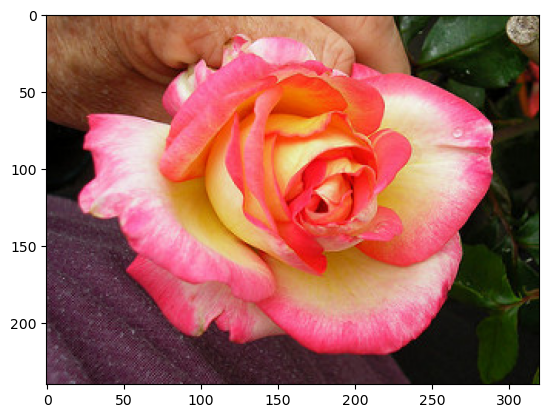

In [5]:
# run this block multiple times to look at some randomly chosen images of roses
import random

rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

In [6]:
print(image.shape)

(240, 320, 3)


We can see that the shape of the image is 3 dimentional (Width, height, channels)

Text(0.5, 0.98, 'Different Channels of Image')

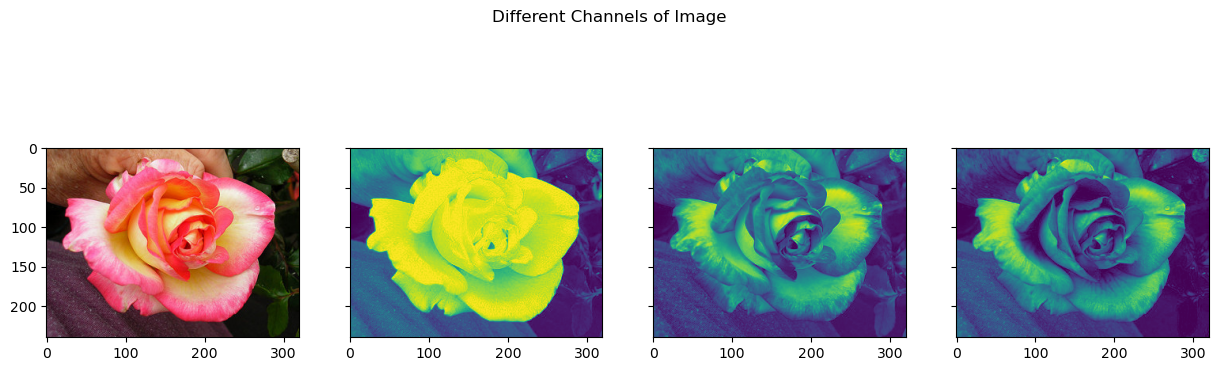

In [7]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

## Morphological Transformations

### Thresholding

> Thresholding is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from color or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, **we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.**

One of the simpler operations where we take all the pixels whose intensities are above a certain threshold, and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a *binary image*.

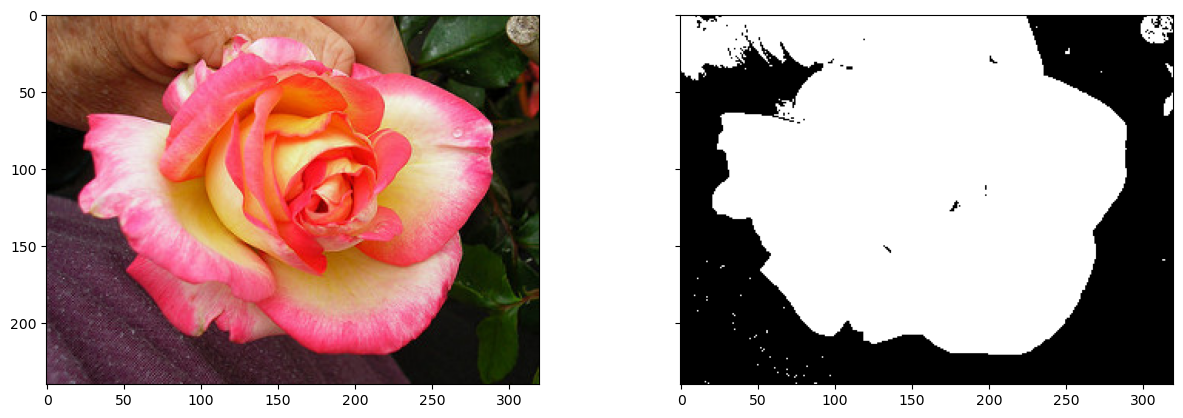

In [8]:
# bin_image will be a True/False array
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

We can see that, all the portions of the image which were light color are now white in color, while all the portion of the image which were dark anr now black completely.

External Reference Material: https://datacarpentry.org/image-processing/07-thresholding/

In the below section, we are going to discuss some of the image preprocessing techniques which can be performed only on binary images. This is the reason we have performed image transformation above.

### Erosion, Dilation, Opening & Closing

* **Erosion** shrinks bright regions and enlarges dark regions. 
* **Dilation** shrinks dark regions and enlarges the bright regions. 

* **Opening** is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

* **Closing** is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

All these can be done using the `skimage.morphology` module. The basic idea is to have a **circular disk** of a certain size (3 below) move around the image and apply these transformations using it.

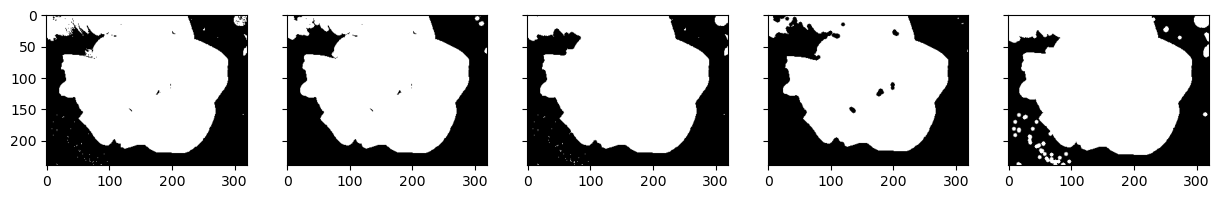

In [9]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import disk

# use a disk of radius 3
selem = disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

## Normalisation 

Normalisation is the most crucial step in the pre-processing part. 

**Reasons for normalization:**

* Contrast: we need to take into account that images might be taken in different lighting conditions.
* Gradient Propagation: Well known concept in DL


Note: In theory we can have image pixel intensity between 0 and 255, but it may not be the case always. Sometimes, image is taken in dark region and thus image may not have bright light as high as 255 intensity.


There are multiple ways to normalise images which we will be talking about.

External Reference: 
* https://www.sciencedirect.com/topics/engineering/image-normalization

* https://arxiv.org/abs/1705.01809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


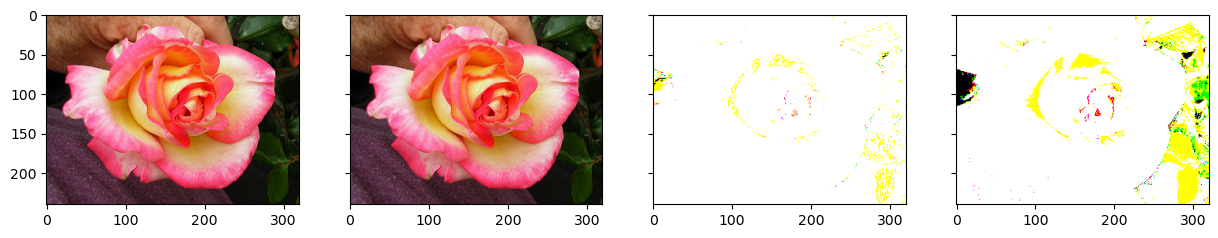

In [10]:
## Normalize image pixel intensity between 0 and 1
norm1_image = image/255
## Min Max Normalization 
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
## Percentile based normalization (To tacle outliers in contrast..)
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

## Augmentations

Many times, the quantity of data that we have is not sufficient to perform the task of classification well enough. In such cases, we perform data augmentation.

**Reasons for doing Augmentation**
* Small training dataset
* Tackling overfitting

We do not want our model to memorize patterns.

There are multiple types of augmentations possible. The basic ones transform the original image using one of the following types of transformations:

1. Linear transformations: These are the transformation techniques where you just multiply your image with some matrix (transformation matrix) to get the transformed image. For example:
    * Rotation
    * Flipping
2. Affine transformations: Translation followed by linear transformation is affine transformation. Translation is centering image i.e moving image center before applying any transformation.

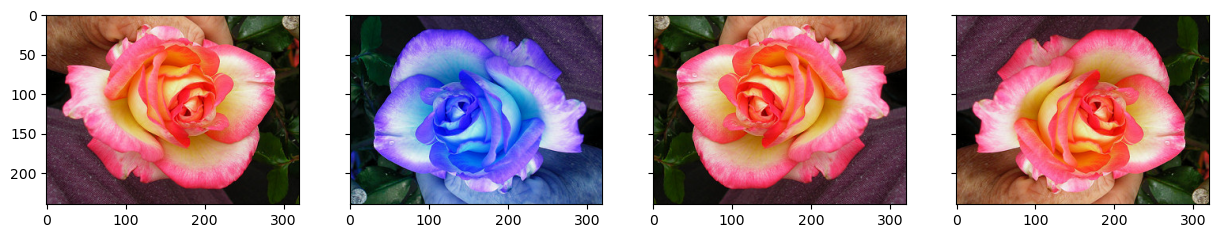

In [11]:
from skimage import transform as tf

# flip left-right, up-down
image_flip = np.flip(image)  # flip image
image_flipr = np.fliplr(image)  # horizontal flip
image_flipud = np.flipud(image) # verticle flip


plot_image([image, image_flip, image_flipr, image_flipud])

Though you can do any type of augmatation, but not all augmentations are applicable everywhere. For example: In above flower case, you can do any side flip that is fine, but say x-ray images you should not flip them vertically.


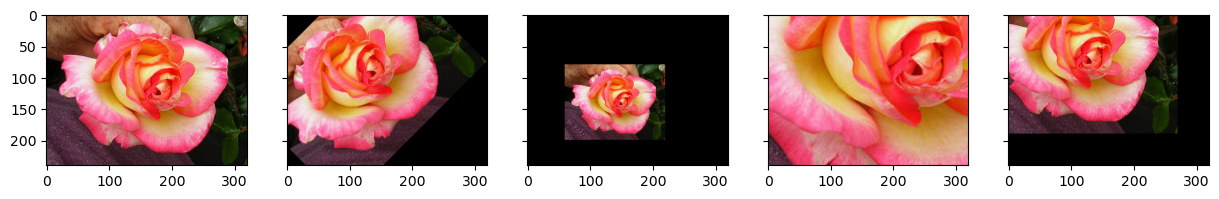

In [12]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = tf.warp(image, rot_matrix)

# scaling (Zooming out image)
scale_transforms = tf.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = tf.warp(image, scale_matrix)

## scaling (Zooming in image)
scale_transforms = tf.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = tf.warp(image, scale_matrix)

# translation
transaltion_transforms = tf.AffineTransform(translation=(50, 50))
translated_image = tf.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


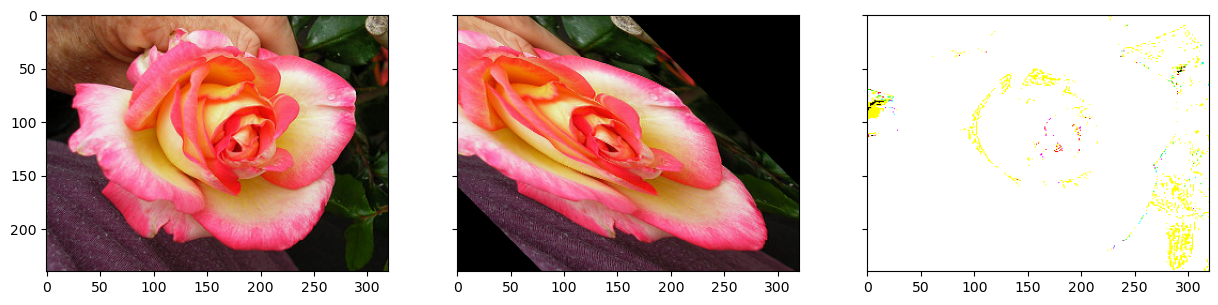

In [13]:
# shear transforms
shear_transforms = tf.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = tf.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

# prepare dataset for the model training

<hr>

In [20]:
for cl in flowers_cls:
  imgs_path = os.path.join(DATASET_PATH, cl) #go into dir with name of flower
  imgs = glob.glob(imgs_path + '/*.jpg') #find all pics in that dir (pic if ends in jpg)
  print(f"{cl}: {len(imgs)} Images")
  train, val = imgs[:round(len(imgs) * 0.8)], imgs[round(len(imgs) * 0.8):] #80-20 split into train/val datasets

  for t in train:
    if not os.path.exists(os.path.join(DATASET_PATH, 'train', cl)): #if a path of format flower_photos/train/[class_name] doesn't exist, make one
      os.makedirs(os.path.join(DATASET_PATH, 'train', cl)) #use makedirs to create train/[class_name] (mkdir would only create [class_name])
    shutil.move(t, os.path.join(DATASET_PATH, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(DATASET_PATH, 'val', cl)): #similar process for validation data
      os.makedirs(os.path.join(DATASET_PATH, 'val', cl)) 
    shutil.move(v, os.path.join(DATASET_PATH, 'val', cl))


daisy: 633 Images
roses: 641 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [21]:
train_dir = os.path.join(DATASET_PATH, 'train')
val_dir = os.path.join(DATASET_PATH, 'val')

In [22]:
## Define Parameters
BATCH_SIZE = 100
IMG_SHAPE = 150

In [33]:
## Data Augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2935 images belonging to 5 classes.


In [34]:
## Validation Data Generator
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 735 images belonging to 5 classes.


In [35]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])


In [36]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
                

In [37]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [38]:
EPOCHS = 100

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


/var/folders/t9/hbbgw33x38nbt4bxdk4t3ylr0000gp/T/ipykernel_18377/751406522.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


2023-07-18 12:27:52.595393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - ETA: 0s - loss: 1.5582 - accuracy: 0.3622

2023-07-18 12:28:07.841580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 17s 555ms/step - loss: 1.5582 - accuracy: 0.3622 - val_loss: 1.1927 - val_accuracy: 0.5143
Epoch 2/100
30/30 [==============================] - 16s 538ms/step - loss: 1.1680 - accuracy: 0.5128 - val_loss: 1.0818 - val_accuracy: 0.5864
Epoch 3/100
30/30 [==============================] - 16s 524ms/step - loss: 1.0676 - accuracy: 0.5772 - val_loss: 1.0205 - val_accuracy: 0.6313
Epoch 4/100
30/30 [==============================] - 16s 554ms/step - loss: 1.0027 - accuracy: 0.6102 - val_loss: 0.9923 - val_accuracy: 0.6422
Epoch 5/100
30/30 [==============================] - 16s 541ms/step - loss: 0.9558 - accuracy: 0.6286 - val_loss: 0.9054 - val_accuracy: 0.6544
Epoch 6/100
30/30 [==============================] - 16s 533ms/step - loss: 0.9079 - accuracy: 0.6457 - val_loss: 0.9060 - val_accuracy: 0.6707
Epoch 7/100
30/30 [==============================] - 17s 553ms/step - loss: 0.8704 - accuracy: 0.6698 - val_loss: 0.9159 - val_accuracy: 0.6354
Epoc

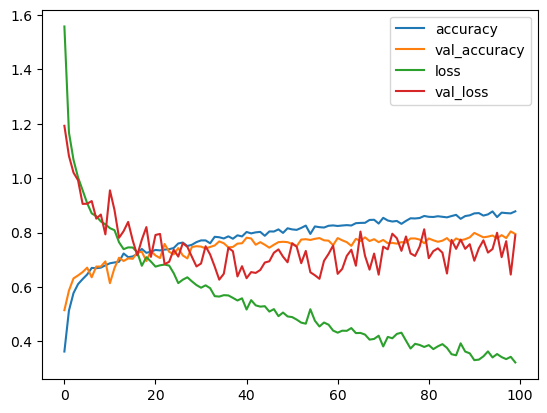

In [39]:
#plot loss and accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()